# Продвинутое машинное обучение: Домашнее задание 2


Студент: Наумовский Алексей \
Группа: DS-22

In [1]:
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
import scipy.stats as stats
from scipy import sparse as sp
from scipy.special import expit
from tqdm import tqdm

from warnings import filterwarnings
%matplotlib inline
filterwarnings('ignore')
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Dataset/chgk
!ls

/content/drive/MyDrive/Dataset/chgk
players.pkl  results.pkl  tournaments.pkl


In [4]:
# укажите путь до датасета:
path_dataset = "/content/drive/MyDrive/Dataset/chgk/"

## 1) Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl)

#### Players:

In [5]:
df_players = pd.DataFrame(pd.read_pickle(path_dataset+'players.pkl')).T
df_players.columns = ['player_id','name','patronymic','surname']
df_players['fname'] =  df_players.apply(lambda x: x['name'] +' '+ x['surname'], axis=1)
df_players = df_players.drop(columns=['name','surname','patronymic']).set_index('player_id')

In [6]:
df_players.sample(5)

,fname
player_id,
111094,Антон Артанов
40180,Ася Балышева
11577,Дарья Зверева
191554,Владимир Землянский
52756,Евгений Дёмин


In [7]:
df_players.describe()

,fname
count,204063
unique,167109
top,Александр Иванов
freq,55


#### Tournaments:

In [8]:
df_tournaments = pd.DataFrame(pd.DataFrame(pd.read_pickle(path_dataset+'tournaments.pkl')).T)
df_tournaments = df_tournaments.drop(columns=['dateEnd','type','season','orgcommittee','synchData','questionQty'])
df_tournaments['dateStart'] =  pd.to_datetime(df_tournaments['dateStart'],utc=True).dt.year
df_tournaments.columns = ['tournament_id','tname','dateStart']
df_tournaments = df_tournaments.set_index('tournament_id')

df_tournaments_train = df_tournaments[df_tournaments['dateStart'] == 2019]
df_tournaments_test = df_tournaments[df_tournaments['dateStart'] == 2020]

In [9]:
print(f'min, max indexes TRAIN tournaments:{(min(df_tournaments_train.index),max(df_tournaments_train.index))}; shape={df_tournaments_train.shape}')
print(f'min, max indexes TEST tournaments:{(min(df_tournaments_test.index),max(df_tournaments_test.index))}; shape={df_tournaments_test.shape}') 

min, max indexes TRAIN tournaments:(4772, 6370); shape=(689, 2)
min, max indexes TEST tournaments:(4628, 6485); shape=(416, 2)


#### Results:

In [10]:
df_results = pd.read_pickle(path_dataset+'results.pkl')

In [11]:
def get_players_results(df_tournaments, df_results):
    results =[]
    question_global_id = 0
    # Все турниры
    for cur_tour_id in df_tournaments.index:
        try:
            # Исключаем игры без маски
            if df_results[cur_tour_id][0]['mask'] == None:
                continue
        except:
            continue
        # Исключаем турниры с разным количеством вопросов в играх
        if len(pd.DataFrame(df_results[cur_tour_id])['mask'].apply(lambda x: len(str(x))).value_counts()) != 1:
            continue
        # Все игры в турнире
        for cur_game in df_results[cur_tour_id]:
            mask = cur_game['mask']
            mask_len = len(str(mask))
            # Исключаем игры с ошибками в результатах (в маске не 0/1)
            if re.findall('[^01]', str(mask)):
                continue
            mask_sum = sum([int(digit) for digit in str(mask)])
            team_id = cur_game['team']['id']
            # Все игроки в текущей игре
            for player in cur_game['teamMembers']:
                player_id = player['player']['id']
                # Все вопросы(для каждого игрока) в текушей игре
                for question_id, answer in zip(np.arange(0, mask_len), str(mask)):
                    results.append([cur_tour_id, team_id, player_id, mask,\
                                    (question_global_id + question_id), np.int32(answer), mask_len, mask_sum])
        question_global_id = question_global_id + mask_len
    return pd.DataFrame(results, columns=['tournament_id','team_id','player_id', 'mask',\
                                          'question_id', 'answer', 'mask_len', 'mask_sum']).set_index('tournament_id')

##### Players results TRAIN

In [12]:
df_train_res_players = get_players_results(df_tournaments_train, df_results)
print(f'Tournaments count TRAIN:{df_train_res_players.index.nunique()}')

Tournaments count TRAIN:602


In [13]:
# Проверим правильно ли проставляется question_id:
df_train_res_players.iloc[30:40]

,team_id,player_id,mask,question_id,answer,mask_len,mask_sum
tournament_id,,,,,,,
4772,45556,6212,111111111011111110111111111100010010,30,0,36,28
4772,45556,6212,111111111011111110111111111100010010,31,1,36,28
4772,45556,6212,111111111011111110111111111100010010,32,0,36,28
4772,45556,6212,111111111011111110111111111100010010,33,0,36,28
4772,45556,6212,111111111011111110111111111100010010,34,1,36,28
4772,45556,6212,111111111011111110111111111100010010,35,0,36,28
4772,45556,18332,111111111011111110111111111100010010,0,1,36,28
4772,45556,18332,111111111011111110111111111100010010,1,1,36,28
4772,45556,18332,111111111011111110111111111100010010,2,1,36,28


In [14]:
print("TOP-20 игороков(TRAIN) по количеству правильно отвеченных(в составе какой-либо команды) вопросов:") 
df_train_res_players.groupby(['player_id'])[['answer']].sum().sort_values(by='answer', ascending=False).nlargest(20, 'answer').\
    merge(df_players, how='inner', on='player_id')   

TOP-20 игороков(TRAIN) по количеству правильно отвеченных(в составе какой-либо команды) вопросов:


,answer,fname
player_id,,
110920,4040,Алексей Дворянчиков
131908,3958,Иван Киселёв
12511,3956,Константин Ильин
20640,3931,Ольга Мельникова
147450,3839,Максим Салихов
117262,3631,Сергей Черкасов
27499,3438,Наталия Рыжанова
149724,3412,Дмитрий Пелихов
26640,3399,Вадим Раскумандрин


In [15]:
print("TOP-20 игороков(TRAIN) по количеству посещенных игр:") 
df_train_res_players[['team_id','player_id']].drop_duplicates().groupby(['player_id'])[['team_id']].\
    count().sort_values(by='team_id', ascending=False).nlargest(20, 'team_id').merge(df_players, how='inner', on='player_id')

TOP-20 игороков(TRAIN) по количеству посещенных игр:


,team_id,fname
player_id,,
16939,54,Сергей Кузнецов
96304,44,Алексей Тырышкин
42511,44,Николай Некрылов
54035,42,Дамир Жадиков
46586,41,Виталий Эйбер
96330,40,Наталья Комар
140245,40,Дмитрий Евменов
117884,39,Олег Шитиков
80593,39,Алексей Шуб


In [16]:
print("TOP-20 игороков(TRAIN) по количеству посещенных турниров:")
df_train_res_players.reset_index()[['tournament_id','player_id']].drop_duplicates().groupby(['player_id'])[['tournament_id']].\
    count().sort_values(by='tournament_id', ascending=False).nlargest(20, 'tournament_id').merge(df_players, how='inner', on='player_id')

TOP-20 игороков(TRAIN) по количеству посещенных турниров:


,tournament_id,fname
player_id,,
20640,184,Ольга Мельникова
12511,183,Константин Ильин
131908,178,Иван Киселёв
147450,176,Максим Салихов
117262,173,Сергей Черкасов
149724,158,Дмитрий Пелихов
110920,157,Алексей Дворянчиков
118444,148,Ирина Липовская
85059,148,Ева Берг


##### Players results TEST

In [17]:
df_test_res_players = get_players_results(df_tournaments_test, df_results)
print(f'Tournaments count TEST:{df_test_res_players.index.nunique()}')

Tournaments count TEST:151


#### Conver to ONEHOT(TRAIN):

In [18]:
print(f'players:{df_train_res_players.question_id.nunique()}, questions:{df_train_res_players.player_id.nunique()\
                                                                         }, rows:{df_train_res_players.shape[0]}')

players:28014, questions:55280, rows:13753671


In [19]:
enc = OneHotEncoder(handle_unknown='ignore')

X_train = enc.fit_transform(df_train_res_players[['player_id', 'question_id']])
y_train = np.array(df_train_res_players['answer'], dtype=np.int32)

In [20]:
X_train.shape, y_train.shape

((13753671, 83294), (13753671,))

## 2) Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. 

Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [21]:
lr_baseline = LogisticRegression(random_state=0, n_jobs=-1)
lr_baseline.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

#### TRAIN metrcis:

Оценим как обучилась наша Baseline модель

              precision    recall  f1-score   support

           0       0.79      0.82      0.80   7827428
           1       0.75      0.71      0.73   5926243

    accuracy                           0.77  13753671
   macro avg       0.77      0.76      0.77  13753671
weighted avg       0.77      0.77      0.77  13753671



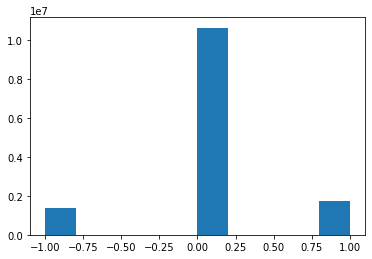

In [22]:
y_predict = np.array(lr_baseline.predict(X_train), dtype=np.int32)
print(metrics.classification_report(y_train, y_predict))
plt.hist(y_train - y_predict);

### Ранжирование игроков (при помощи коэффициентов логистической регресси):

In [23]:
players = np.unique(df_train_res_players['player_id'])                  
df_train_rate = pd.DataFrame({'player_id': players,
                       'strength': lr_baseline.coef_[0][:len(players)]})

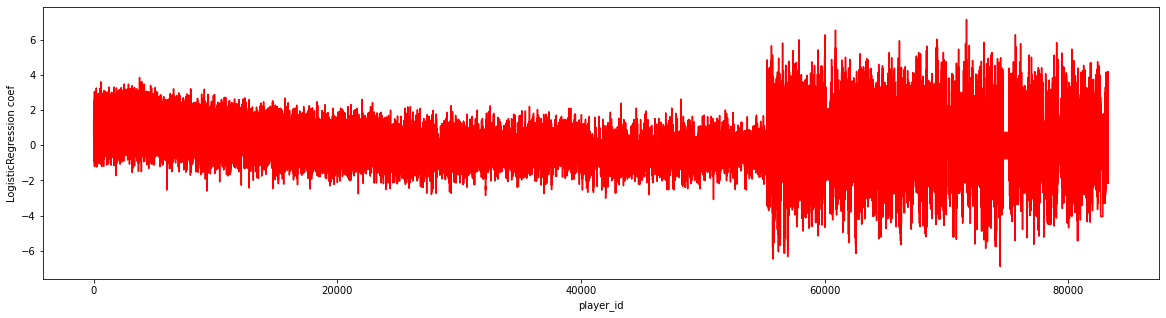

In [24]:
f, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(lr_baseline.coef_[0], color='Red')
ax.set_xlabel('player_id')
ax.set_ylabel('LogisticRegression coef');

In [25]:
print("TOP-20 игороков(TRAIN) на основе ранжирования по коэффициентам логистической регрессии:") 
df_train_rate_final = df_train_rate.merge(df_players, how='inner', on='player_id')
df_train_rate_final = df_train_rate_final.sort_values(by='strength', ascending=False)
df_train_rate_final.head(20)

TOP-20 игороков(TRAIN) на основе ранжирования по коэффициентам логистической регрессии:


,player_id,strength,fname
3766,27403,3.864046,Максим Руссо
585,4270,3.614264,Александра Брутер
3953,28751,3.613494,Иван Семушин
3837,27822,3.576068,Михаил Савченков
2505,18036,3.486332,Михаил Левандовский
2856,20691,3.482016,Станислав Мереминский
4157,30270,3.480629,Сергей Спешков
4152,30260,3.416436,Евгений Спектор
4673,34328,3.411907,Михаил Царёв
3808,27622,3.394032,Николай Рябых


In [26]:
print("Количество правильно отвеченных(в составе какой-либо команды) вопросов для TOP-20 отранжированных игроков(TRAIN):") 
df_train_res_players[df_train_res_players.player_id.isin(df_train_rate_final.head(20).player_id)].\
    groupby(['player_id'])[['answer']].sum().\
    sort_values(by='answer', ascending=False).nlargest(20, 'answer').\
    merge(df_players, how='inner', on='player_id') 

Количество правильно отвеченных(в составе какой-либо команды) вопросов для TOP-20 отранжированных игроков(TRAIN):


,answer,fname
player_id,,
30152,3034,Артём Сорожкин
28751,2385,Иван Семушин
30270,2283,Сергей Спешков
27822,2056,Михаил Савченков
4270,1759,Александра Брутер
27403,1411,Максим Руссо
20691,989,Станислав Мереминский
1585,954,Юлия Архангельская
16332,924,Николай Крапиль


В целом результаты считаю удовлетворительными.

## 3) Качество рейтинг-системы


Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе.

Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Силу команд оценим как вероятность того, что хотя бы один участник ответит верно на 1 вопрос (сложность вопроса учитывать не будем)

#### Conver to ONEHOT(TEST):

In [27]:
# Возьмем игроков, которые есть и в TRAIN
df_test_players_in_train = df_test_res_players[df_test_res_players.player_id.isin(players)]
df_test_players_in_train = df_test_players_in_train.reset_index()
df_test_players_in_train = df_test_players_in_train.sort_values(by=['tournament_id','team_id','player_id'])
df_test_players_in_train = df_test_players_in_train.drop(columns=['answer','question_id']).drop_duplicates()

In [28]:
# Теперь все вопросы у нас новые
df_test_players_in_train['question_id'] = -1

In [29]:
X_test = df_test_players_in_train[['player_id', 'question_id']]
X_test = enc.transform(X_test)

#### Predict TEST:

In [30]:
y_predicts = lr_baseline.predict_proba(X_test)[:, 1]

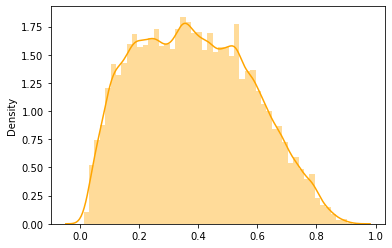

In [31]:
sns.distplot(y_predicts, color='Orange');

#### Real RATE:

Оценим реальный рейтинг команд

In [32]:
df_test_players_in_train['proba_predict'] = y_predicts
df_test_players_in_train['score'] = df_test_players_in_train.groupby(['tournament_id', 'team_id'])['proba_predict'].\
                                        transform(lambda x: 1 - np.prod(1 - x))

In [33]:
df_test_rating = df_test_players_in_train[['tournament_id', 'team_id', 'mask_sum', 'score']].\
                    drop_duplicates().reset_index(drop=True)                  

In [34]:
df_test_rating = df_test_rating.sort_values(by=['tournament_id', 'mask_sum'], ascending=False)  
df_test_rating['rate'] = df_test_rating.groupby('tournament_id')['mask_sum'].transform(lambda x: np.arange(1, len(x) + 1))

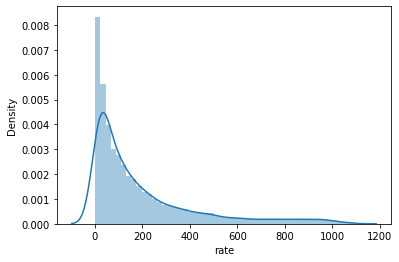

In [35]:
sns.distplot(df_test_rating['rate']);

#### Predict RATE:

Оценим предсказанный рейтинг команд

In [36]:
df_test_rating = df_test_rating.sort_values(by=['tournament_id', 'score'], ascending=False)  
df_test_rating['rate_predict'] = df_test_rating.groupby('tournament_id')['score'].transform(lambda x: np.arange(1, len(x) + 1))
df_test_rating['rate_predict'] = df_test_rating['rate_predict'].astype(np.int32)

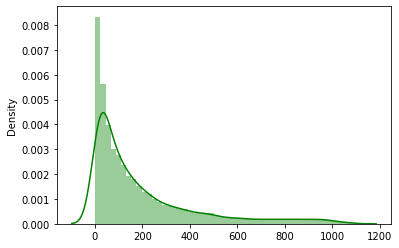

In [37]:
sns.distplot(df_test_rating[['rate_predict']], color='Green');

In [38]:
df_test_rating['rate'] = df_test_rating['rate'].astype(np.int32)

#### Correlation:

Оценим качество baseline модели при помощи корреляции

In [39]:
    print(f"Корреляция Спирмана: {df_test_rating.groupby('tournament_id').\
                                  apply(lambda x: stats.spearmanr(x['rate'], x['rate_predict']).correlation).mean()}")
    print(f"Корреляция Кендалла: {df_test_rating.groupby('tournament_id').\
                                  apply(lambda x: stats.kendalltau(x['rate'], x['rate_predict']).correlation).mean()}")

Корреляция Спирмана: 0.7831739130357943
Корреляция Кендалла: 0.6148772825995495


Похоже, что всё в порядке

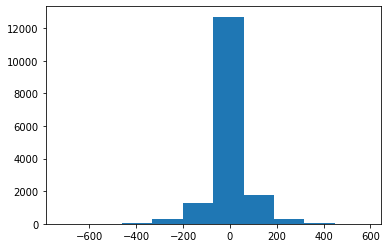

In [40]:
plt.hist(df_test_rating['rate'] - df_test_rating['rate_predict']);

## 4) Теперь главное: ЧГК — это всё-таки командная игра. EM алгоритм

* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.



До этого мы считали, что если команда ответила на вопрос, то и игрок на него ответил. На самом деле это не так, и нам нужно оценить вероятность ответа игрока при условии "силы команды". 
* Предлагаю попробовать считать "силой команды", как и ранее, вероятность хотя бы одного игрока ответить на вопрос. 
* Также предположим, что "сила команды", если игрок ответил верно, равна 1. \

Тогда: \
<font color='PaleGreen'>
$ P(player = 1|team) = \frac{P(team|player = 1)\cdot P(player = 1)}{P(team)} = \frac{P(player = 1)}{P(team)} $, \
</font>
Также будем считать, что <font color='PaleGreen'> $ P(player = 1 | team ) = 0 $ </font>, если команда ответила на вопрос неверно. \

Соответсвенно, на E-шаге оцениваем <font color='PaleGreen'> $ P(player = 1 | team) $ </font>, а на M-шаге обучаем логистическую регрессию на этом таргете, на выходе получаем значения <font color='PaleGreen'> $ P(player = 1) $ </font>. \

<font color='PaleGreen'> $ P(team) $ </font>, как и ранее, оцениваем как вероятность того, что хотя бы 1 игрок ответит верно: <font color='PaleGreen'> $ P(team) = 1 - П[1 - P(player = 1)] $ </font>

In [41]:
def compute_correlation(data, preds):
    data['pred'] = preds
    data['score'] = data.groupby(['tournament_id', 'team_id'])['pred'].transform(lambda x: 1 - np.prod(1 - x))
    rating = data[['tournament_id', 'team_id', 'mask_sum', 'score']].drop_duplicates().reset_index(drop=True)
    
    # Считаем реальный рейтинг команд
    rating = rating.sort_values(by=['tournament_id', 'mask_sum'], ascending=False)
    rating['real_rank'] = rating.groupby('tournament_id')['mask_sum'].transform(lambda x: np.arange(1, len(x) + 1))
    
    # Считаем предсказанный рейтинг
    rating = rating.sort_values(by=['tournament_id', 'score'], ascending=False)
    rating['pred_rank'] = rating.groupby('tournament_id')['score'].transform(lambda x: np.arange(1, len(x) + 1))

    rating = rating.astype(np.int32)
    
    print(f"Корреляция Спирмана: {rating.groupby('tournament_id').apply(lambda x: stats.spearmanr(x['real_rank'], x['pred_rank']).correlation).mean()}")
    print(f"Корреляция Кендалла: {rating.groupby('tournament_id').apply(lambda x: stats.kendalltau(x['real_rank'], x['pred_rank']).correlation).mean()}")

In [42]:
def log_loss(y_true, y_pred):
    return - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

class EMClassifier:
    
    def __init__(self, w=None, lr=25, n_iter=10, batch_size=5000, verbose=1):
        self.w = w
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.verbose = 1
        
    def _add_intercept(self, X):
        return sp.hstack((np.ones((X.shape[0], 1)), X), format='csr')
    
    def _init_w(self, dim):
        self.w = np.random.randn(dim)
        
    def _E_step(self, data, preds):
        team_strength = pd.DataFrame({'team_id': data['team_id'],
                                      'question_id': data['question_id'], 
                                      'team_strength': 1 - preds})
        team_strength = team_strength.groupby(['team_id', 'question_id']).agg({'team_strength': 'prod'}).reset_index()
        team_strength['team_strength'] = 1 - team_strength['team_strength']
        team_strength = data[['team_id', 'question_id']].merge(team_strength)
        y = np.clip(preds / team_strength['team_strength'], 0, 1).values # переведем к вероятностям
        y[data['answer'] == 0] = 0
        return y
        
    def _M_step(self, X, y):
        # Обучаем LogReg батчевым градиентным спуском, чтобы выскакивать из локальных минимумов
        min_loss = np.inf
        indices = np.arange(X.shape[0])
        for _ in range(100):
            indices = np.random.permutation(indices)
            for batch_idx in np.array_split(indices, len(indices) // self.batch_size):
                x_batch, y_batch = X[batch_idx], y[batch_idx]
                grad = x_batch.T.dot(self.predict(x_batch) - y_batch) / len(y_batch)
                self.w -= self.lr * grad
                
            cur_loss = log_loss(y, self.predict(X))
            if min_loss - cur_loss < 1e-6:
                break
                
            min_loss = cur_loss
                
    def fit(self, X_tr, train_data, X_te=None, test_data=None):
        X_tr = self._add_intercept(X_tr)
        if self.w is None or len(self.w) != X_tr.shape[1]:
            self._init_w(X_tr.shape[1])
        
        for iter_ in tqdm(range(self.n_iter)): 
            preds = self.predict(X_tr)
            y = self._E_step(train_data, preds)
            self._M_step(X_tr, y)
            if self.verbose is not None and X_te is not None and test_data is not None and iter_ % self.verbose == 0:
                compute_correlation(test_data, self.predict(X_te))
                         
    def predict(self, X):
        if self.w is None:
            raise ValueError('Model is not fitted yet!')
        if len(self.w) != X.shape[1]:
            X = self._add_intercept(X)
        return expit(X.dot(self.w))

In [43]:
w_init = np.hstack([lr_baseline.intercept_, lr_baseline.coef_[0]])
em_classifier = EMClassifier(w_init)

In [44]:
em_classifier.fit(X_train, df_train_res_players, X_test, df_test_players_in_train)

 10%|█         | 1/10 [04:40<42:02, 280.33s/it]

Корреляция Спирмана: 0.794264620964824
Корреляция Кендалла: 0.6250322022283636


 20%|██        | 2/10 [07:01<31:48, 238.51s/it]

Корреляция Спирмана: 0.7986480664330139
Корреляция Кендалла: 0.6284599272357874


 30%|███       | 3/10 [08:36<22:48, 195.46s/it]

Корреляция Спирмана: 0.7948292042465233
Корреляция Кендалла: 0.6246989591280073


 40%|████      | 4/10 [12:14<20:12, 202.15s/it]

Корреляция Спирмана: 0.7940954462979186
Корреляция Кендалла: 0.6232597734384703


 50%|█████     | 5/10 [15:55<17:20, 208.01s/it]

Корреляция Спирмана: 0.7947728192389487
Корреляция Кендалла: 0.6247616338926392


 60%|██████    | 6/10 [17:25<11:30, 172.63s/it]

Корреляция Спирмана: 0.7946593342192035
Корреляция Кендалла: 0.6242245215385305


 70%|███████   | 7/10 [19:19<07:44, 154.86s/it]

Корреляция Спирмана: 0.7957641869629156
Корреляция Кендалла: 0.6248030158584809


 80%|████████  | 8/10 [21:43<05:03, 151.66s/it]

Корреляция Спирмана: 0.7967942102185664
Корреляция Кендалла: 0.6259710637229831


 90%|█████████ | 9/10 [23:37<02:20, 140.33s/it]

Корреляция Спирмана: 0.7981471755265783
Корреляция Кендалла: 0.6280347630232719


100%|██████████| 10/10 [24:57<00:00, 149.76s/it]

Корреляция Спирмана: 0.7988788831326677
Корреляция Кендалла: 0.628603135268428


Есть неплохой прирост относительно baseline

## 5) А что там с вопросами? 


Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

Сложность турнира посчитаем как среднюю сложность вопроса - возьмем средние коэффициенты нашей модели.

In [45]:
unique_questions = np.unique(df_train_res_players['question_id'])
questions_rating = dict(zip(unique_questions, em_classifier.w[-len(unique_questions):]))

df_train_res_players['difficulty'] = df_train_res_players['question_id'].map(questions_rating)

In [46]:
df_train_res_players = df_train_res_players.merge(df_tournaments_train, how='left', on='tournament_id')

In [47]:
tournaments_rating = df_train_res_players[['tname', 'question_id', 'difficulty']].drop_duplicates()
tournaments_rating = tournaments_rating.groupby('tname')['difficulty'].mean().sort_values().reset_index()

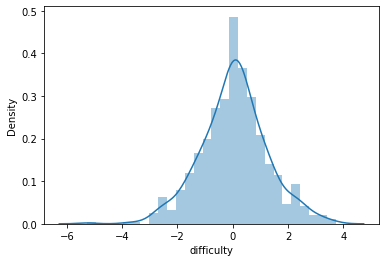

In [48]:
sns.distplot(tournaments_rating.difficulty);

In [49]:
# TOP-20 Самых сложных турниров по версии модели
tournaments_rating.head(20)

,tname,difficulty
0,Чемпионат Санкт-Петербурга. Первая лига,-5.264520
1,Угрюмый Ёрш,-3.744897
2,Первенство правого полушария,-3.403242
3,Кубок городов,-2.969011
4,Воображаемый музей,-2.938452
5,Ускользающая сова,-2.835106
6,Записки охотника,-2.796460
7,Чемпионат России,-2.786695
8,All Cats Are Beautiful,-2.621887
9,VERSUS: Коробейников vs. Матвеев,-2.591273


In [50]:
# TOP-20 Самых простых турниров по версии модели
tournaments_rating.tail(20).sort_values(by='difficulty',ascending=False)

,tname,difficulty
595,(а)Синхрон-lite. Лига старта. Эпизод V,3.728038
594,(а)Синхрон-lite. Лига старта. Эпизод III,3.547253
593,(а)Синхрон-lite. Лига старта. Эпизод IX,3.310530
592,(а)Синхрон-lite. Лига старта. Эпизод XI,3.307611
591,(а)Синхрон-lite. Лига старта. Эпизод VI,3.108716
590,(а)Синхрон-lite. Лига старта. Эпизод VII,3.089142
589,Второй тематический турнир имени Джоуи Триббиани,3.062030
588,Синхрон-lite. Выпуск XXX,2.944583
587,(а)Синхрон-lite. Лига старта. Эпизод IV,2.894080
586,(а)Синхрон-lite. Лига старта. Эпизод X,2.842132


## 6) Постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли.

In [51]:
players_rating = pd.DataFrame({'player_id': players,
                       'strength': em_classifier.w[1:1 + len(players)]})
players_rating['questions_count'] = players_rating['player_id'].map(df_train_res_players.groupby('player_id')['question_id'].count())
players_rating = players_rating.merge(df_players, how='inner', on='player_id')

In [52]:
players_rating.sort_values(by='strength', ascending=False).head(50)

,player_id,strength,questions_count,fname
3766,27403,7.533775,1796,Максим Руссо
585,4270,7.319207,2240,Александра Брутер
3953,28751,7.293631,3071,Иван Семушин
3837,27822,7.241461,2666,Михаил Савченков
4137,30152,6.878911,4006,Артём Сорожкин
4157,30270,6.842704,3017,Сергей Спешков
2856,20691,6.499173,1370,Станислав Мереминский
9082,87637,6.371753,927,Антон Саксонов
2505,18036,6.324260,1113,Михаил Левандовский
964,7008,6.317377,3493,Алексей Гилёв
